Inherited from https://www.kaggle.com/davidedwards1/tabularmarch21-dae-starter-cv-inference

In [1]:
import torch
import numpy as np
from datetime import datetime
import pickle
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import pandas as pd
import gc
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import StratifiedKFold
import pickle

If you find this notebook useful, please visit original discussion post (#1 Solution in Feb21 Comp, which is where I have taken this code from) and upvote.

https://www.kaggle.com/c/tabular-playground-series-feb-2021/discussion/222745

And winning solution from Jan

https://www.kaggle.com/c/tabular-playground-series-jan-2021/discussion/216037

Some credit with regards to pytorch code is also due to this notebook below from MOA competition. I've modified the code quite a bit since then but the outline is probably still recognisable.

https://www.kaggle.com/namanj27/new-baseline-pytorch-moa/notebook

In [2]:
def seed_everything(seed=42):
    print('Setting Random Seed')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

The weights used in this notebook are loaded from a run following the code in the DAE training notebook.

https://www.kaggle.com/davidedwards1/tabularmarch21-dae-starter

In [3]:
PATH = '/kaggle/input/tabular-playground-series-mar-2021/'
SAVE_PATH = ''

run_key = 'MLPMARTAB_00002'

CFG = {'debug':False,
       'debug_epochs':2,
    'lr' : 0.00005,
    'weight_decay':9.72918866945795E-06,
    'epochs':10,
    'device':'cuda',
    'early_stopping_steps':4,
    'early_stop':False,
    'nfolds':5,       
    'mlp_hidden_size':391,
       'mlp_size_decline' : 1.0,
    'mlp_batch_size':512,
    'mlp_dropout':0.35,
       'bce_smooth' : 0.001,
    'target_dae' : '/kaggle/input/tabmar21-dae-stage1/',
'target_epoch' : 'model_checkpoint.pth',
       'random_seeds':[0,42]
    }

if CFG['debug']:
    CFG['epochs'] = CFG['debug_epochs']

with open(SAVE_PATH+f"{run_key}_CFG", 'wb') as f:
    pickle.dump(CFG, f)

In [4]:
fts_categorical = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 
                   'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']

fts_continuous = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

#unique counts should be the count of train PLUS test
unique_counts=[  2,  15,  19,  13,  20,  84,  16,  51,  61,  19, 307,   2,   2,
         2,   2,   4,   4,   4,   4]

print('Categorical Features', fts_categorical)
print('Continuous Features', fts_continuous)

print('Categorical Feature Count', len(fts_categorical))
print('Continuous Feature Count', len(fts_continuous))

Categorical Features ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']
Continuous Features ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']
Categorical Feature Count 19
Continuous Feature Count 11


In [5]:
#this is just to control settings for the DAE hidden size etc, there is no further training of the DAE in this notebook

DAE_CFG = {'batch_size' : 384,
    'init_lr' : 3e-4,
    'lr_decay' : .998,
    'noise_decay' : 0.999,
    'max_epochs' : 600,
    'save_freq':50,
    'hidden_size':1024,
    'num_subspaces':8,
    'embed_dim':128,
    'num_heads':8,
    'dropout':0,
    'feedforward_dim':512,
    'emphasis':.75,
    'task_weights':[len(fts_categorical), len(fts_continuous)],
    'mask_loss_weight':2,
    'prob_categorical' : 0.5,
    'prob_continuous' : 0.5,}


model_params = dict(
    hidden_size=DAE_CFG['hidden_size'],
    num_subspaces=DAE_CFG['num_subspaces'],
    embed_dim=DAE_CFG['embed_dim'],
    num_heads=DAE_CFG['num_heads'],
    dropout=DAE_CFG['dropout'],
    feedforward_dim=DAE_CFG['feedforward_dim'],
    emphasis=DAE_CFG['emphasis'],
    mask_loss_weight=DAE_CFG['mask_loss_weight']
)

# DAE Code

In [6]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset

def get_data():
    train_data = pd.read_csv(PATH+'train.csv')
    test_data = pd.read_csv(PATH+'test.csv')
    
    #combine train and test data vertically
    X_nums = np.vstack([
        train_data.iloc[:, 20:-1].to_numpy(),
        test_data.iloc[:, 20:].to_numpy()
    ])
    X_nums = (X_nums - X_nums.mean(0)) / X_nums.std(0) #normalize
    
    #stack the categorical data
    X_cat = np.vstack([
        train_data.iloc[:, 1:20].to_numpy(),
        test_data.iloc[:, 1:20].to_numpy()
    ])
    #encode the categoricals
    encoder = OneHotEncoder(sparse=False)
    X_cat = encoder.fit_transform(X_cat)
    
    #join the categorical and continuous data horizontally
    X = np.hstack([X_cat, X_nums])
    y = train_data['target'].to_numpy().reshape(-1, 1)
    return X, y, X_cat.shape[1], X_nums.shape[1] #this lets us know how many categorical and continuous features there are


class SingleDataset(Dataset):
    def __init__(self, x, is_sparse=False):
        self.x = x.astype('float32')
        self.is_sparse = is_sparse

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        x = self.x[index]
        if self.is_sparse: x = x.toarray().squeeze()
        return x    

In [7]:
bce_logits = torch.nn.functional.binary_cross_entropy_with_logits
mse = torch.nn.functional.mse_loss

class TransformerEncoder(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, feedforward_dim):
        super().__init__()
        self.attn = torch.nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear_1 = torch.nn.Linear(embed_dim, feedforward_dim)
        self.linear_2 = torch.nn.Linear(feedforward_dim, embed_dim)
        self.layernorm_1 = torch.nn.LayerNorm(embed_dim)
        self.layernorm_2 = torch.nn.LayerNorm(embed_dim)
    
    def forward(self, x_in):
        attn_out, _ = self.attn(x_in, x_in, x_in)
        x = self.layernorm_1(x_in + attn_out)
        ff_out = self.linear_2(torch.nn.functional.relu(self.linear_1(x)))
        x = self.layernorm_2(x + ff_out)
        return x


class TransformerAutoEncoder(torch.nn.Module):
    def __init__(
            self, 
            num_inputs, 
            n_cats, 
            n_nums, 
            hidden_size=1024, 
            num_subspaces=8,
            embed_dim=128, 
            num_heads=8, 
            dropout=0, 
            feedforward_dim=512, 
            emphasis=.75, 
            task_weights=[len(fts_categorical), len(fts_continuous)],
            mask_loss_weight=2,
        ):
        super().__init__()
        assert hidden_size == embed_dim * num_subspaces
        self.n_cats = n_cats
        self.n_nums = n_nums
        self.num_subspaces = num_subspaces
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.emphasis = emphasis
        self.task_weights = np.array(task_weights) / sum(task_weights)
        self.mask_loss_weight = mask_loss_weight

        self.excite = torch.nn.Linear(in_features=num_inputs, out_features=hidden_size)
        self.encoder_1 = TransformerEncoder(embed_dim, num_heads, dropout, feedforward_dim)
        self.encoder_2 = TransformerEncoder(embed_dim, num_heads, dropout, feedforward_dim)
        self.encoder_3 = TransformerEncoder(embed_dim, num_heads, dropout, feedforward_dim)
        
        
        self.mask_predictor = torch.nn.Linear(in_features=hidden_size, out_features=num_inputs)
        self.reconstructor = torch.nn.Linear(in_features=hidden_size + num_inputs, out_features=num_inputs)

    def divide(self, x):
        batch_size = x.shape[0]
        x = x.reshape((batch_size, self.num_subspaces, self.embed_dim)).permute((1, 0, 2))
        return x

    def combine(self, x):
        batch_size = x.shape[1]
        x = x.permute((1, 0, 2)).reshape((batch_size, -1))
        return x

    def forward(self, x):
        x = torch.nn.functional.relu(self.excite(x))
        
        x = self.divide(x)
        x1 = self.encoder_1(x)
        x2 = self.encoder_2(x1)
        x3 = self.encoder_3(x2)
        x = self.combine(x3)
        
        predicted_mask = self.mask_predictor(x)
        reconstruction = self.reconstructor(torch.cat([x, predicted_mask], dim=1))
        return (x1, x2, x3), (reconstruction, predicted_mask)

    def split(self, t):
        return torch.split(t, [self.n_cats, self.n_nums], dim=1)

    def feature(self, x):
        attn_outs, _ = self.forward(x)
        return torch.cat([self.combine(x) for x in attn_outs], dim=1)

    def loss(self, x, y, mask, reduction='mean'):        
        _, (reconstruction, predicted_mask) = self.forward(x)
        
        x_cats, x_nums = self.split(reconstruction)
        y_cats, y_nums = self.split(y)
        w_cats, w_nums = self.split(mask * self.emphasis + (1 - mask) * (1 - self.emphasis))
        cat_loss = self.task_weights[0] * torch.mul(w_cats, bce_logits(x_cats, y_cats, reduction='none'))
        num_loss = self.task_weights[1] * torch.mul(w_nums, mse(x_nums, y_nums, reduction='none'))
        
        reconstruction_loss = torch.cat([cat_loss, num_loss], dim=1) if reduction == 'none' else cat_loss.mean() + num_loss.mean()
        
        mask_loss = self.mask_loss_weight * bce_logits(predicted_mask, mask, reduction=reduction)

        return reconstruction_loss + mask_loss if reduction == 'mean' else [reconstruction_loss, mask_loss]


# Smoothed BCE Loss

Note: I don't observe a huge benefit from smoothing - maybe a small gain from a very small smoothing amount. Just used this to have the option. There are some good discussions / notebooks on label smoothing elsewhere on Kaggle if not familiar.

In [8]:
from torch.nn.modules.loss import _WeightedLoss

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)        
        
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# Define MLP and Training Cycle

In [9]:
class FeatureDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx], dtype=torch.float)            
        }
        return dct    
    
class TestFeatureDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),   
        }
        return dct

class Model(nn.Module):
    def __init__(self, num_features=3000, num_targets=1, hidden_size=1000):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(CFG['mlp_dropout'])
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(CFG['mlp_dropout'])
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, int(hidden_size*CFG['mlp_size_decline'])))
        
        self.batch_norm3 = nn.BatchNorm1d(int(hidden_size*CFG['mlp_size_decline']))
        self.dropout3 = nn.Dropout(CFG['mlp_dropout'])
        self.dense3 = nn.utils.weight_norm(nn.Linear(int(hidden_size*CFG['mlp_size_decline']), num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x
    
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device=CFG['device']):
    model.train()
    final_loss = 0    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        
        optimizer.step()
        scheduler.step()        
        final_loss += loss.item()        
    final_loss /= len(dataloader)    
    return final_loss

def valid_fn(model, loss_fn, dataloader, device=CFG['device']):
    model.eval()
    final_loss = 0
    valid_preds = []    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device=CFG['device']):
    model.eval()
    preds = []
    for data in dataloader:
        inputs = data['x'].to(device)
        with torch.no_grad():
            outputs = model(inputs)
        #this predicts by BATCH requiring listing and concatenation
        preds.append(outputs.sigmoid().detach().cpu().numpy())
    
    #then we need to concatenate the list of batches
    preds = np.concatenate(preds).reshape(-1,)  
    return preds

def run_training(X, y, test_df,folds, seed=42,batch_size=256, model_name='model',
               num_features=3000,
            num_targets=1,
            hidden_size=1000,
                device=CFG['device']):  


    training_history = pd.DataFrame(index=range(CFG['epochs']),
                                    data=0.0,
                                    columns=[f'val_{x}' for x in range(CFG['nfolds'])]+[f'trn_{x}' for x in range(CFG['nfolds'])])
    
    seed_everything(seed)    
    
    #placeholder - out of fold predictions
    oof = np.zeros((len(X), ))
    
    #placeholder - test predictions
    predictions = np.zeros((len(test_df), ))
    
    #placeholder - training/validation graph
    fig,axes=plt.subplots(figsize=(18,6))
    axes.set_title(f'Training and Validation Losses for Random Seed {seed}')
    tr_leg = mpatches.Patch(color='Blue', label="Training Losses" )
    val_leg = mpatches.Patch(color='Red', label="Validation Losses" )
    axes.legend(handles=[tr_leg,val_leg],facecolor='White')
    
    #fold losses list
    fold_losses = []
    
    for fold in sorted(np.unique(folds,return_counts=False)): 
        train_idx=folds[:300000]!=fold
        valid_idx=folds[:300000]==fold
            
        print('     ')
        print(f'training for fold {fold}')
        #create the data set
        train_dataset = FeatureDataset(X[train_idx], y[train_idx])
        valid_dataset = FeatureDataset(X[valid_idx], y[valid_idx])

        #apply to the data loader
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

        #create the model itself
        model = Model(
            num_features=num_features,
            num_targets=num_targets,
            hidden_size=hidden_size,
        )

        #send to device and set up the loss and optimizer
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                                  max_lr=1e-2, epochs=CFG['epochs'], steps_per_epoch=len(trainloader))

        loss_fn = nn.BCEWithLogitsLoss()
        loss_tr = SmoothBCEwLogits(smoothing =CFG['bce_smooth'])

        early_stopping_steps = CFG['early_stopping_steps']
        best_loss = np.inf

        train_loss_list = []
        valid_loss_list = []

        for epoch in range(CFG['epochs']):
            #the below updates the model and loss
            train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, device)            
            train_loss_list+=[train_loss]
            
            #the below returns the validation predictions for the fold for each epoch
            valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, device)
            valid_loss_list+=[valid_loss]            
            
            print(f"SEED: {seed}, FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
            
            if valid_loss < best_loss:
                #continue training if improving
                best_loss = valid_loss
                oof[valid_idx] = valid_preds.reshape(-1,)
                torch.save(model.state_dict(), f"MODEL_{model_name}_FOLD_{fold}SEED{seed}_.pth")

            elif(CFG['early_stop']):
                #stop training if not improving
                early_step += 1
                if (early_step >= early_stopping_steps):
                    break

        training_history[f'val_{fold}'] = valid_loss_list
        training_history[f'trn_{fold}'] = train_loss_list                    
                    
        fold_losses += [valid_loss_list[-1]]
                    
        del trainloader, validloader, train_dataset, valid_dataset
        gc.collect()

        sns.lineplot(x=range(CFG['epochs']), y=pd.Series(train_loss_list), color='Blue', ax=axes)
        sns.lineplot(x=range(CFG['epochs']), y=pd.Series(valid_loss_list), color='Red', ax=axes)
        
        #--------------------- PREDICTION---------------------
        #predict test data for fold
        testdataset = TestFeatureDataset(test_df)
        testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=False)

        #we create the model and then we input the latest weights
        model = Model(
            num_features=num_features,
            num_targets=num_targets,
            hidden_size=hidden_size,
        )

        model.load_state_dict(torch.load(f"MODEL_{model_name}_FOLD_{fold}SEED{seed}_.pth"))
        model.to(device)

        #predictions need to be added for the fold
        predictions += inference_fn(model, testloader, device)            
    
    print('finished with fold losses', fold_losses)
    
    predictions/=CFG['nfolds']

    training_history.to_csv(SAVE_PATH+f'mlp_{run_key}_seed_{seed}_training_history.csv', index=False)

    return oof, predictions

# Load DAE Weights from Stack Training

In [10]:
#  get data
X, Y, n_cats, n_nums = get_data()

model_params = dict(
    hidden_size=DAE_CFG['hidden_size'],
    num_subspaces=DAE_CFG['num_subspaces'],
    embed_dim=DAE_CFG['embed_dim'],
    num_heads=DAE_CFG['num_heads'],
    dropout=DAE_CFG['dropout'],
    feedforward_dim=DAE_CFG['feedforward_dim'],
    emphasis=DAE_CFG['emphasis'],
    mask_loss_weight=DAE_CFG['mask_loss_weight']
)

# setup model
model = TransformerAutoEncoder(
    num_inputs=X.shape[1],
    n_cats=n_cats,
    n_nums=n_nums,
    **model_params
).cuda()

model_state = torch.load(CFG['target_dae']+CFG['target_epoch'])
model.load_state_dict(model_state['model'])

print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=DAE_CFG['init_lr'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=DAE_CFG['lr_decay'])

TransformerAutoEncoder(
  (excite): Linear(in_features=642, out_features=1024, bias=True)
  (encoder_1): TransformerEncoder(
    (attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
    )
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=128, bias=True)
    (layernorm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (encoder_2): TransformerEncoder(
    (attn): MultiheadAttention(
      (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
    )
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=128, bias=True)
    (layernorm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layernorm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (encoder_3): TransformerEn

# Create Folds for CV

In [11]:
print('Using Simple Target Stratified KFold')

skf = StratifiedKFold(n_splits=CFG['nfolds'], random_state=42,
                          shuffle=True)

folds=np.zeros((len(X),)).astype(np.int32)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X[:300000], Y)):
    folds[val_idx] = fold

fold_values = sorted(np.unique(folds,return_counts=False))
fold_values

Using Simple Target Stratified KFold


[0, 1, 2, 3, 4]

# Create Features from DAE

In [12]:
# extract features
print('Creating Train Features')
dl = DataLoader(dataset=SingleDataset(X[0:300000]), batch_size=1024, shuffle=False, pin_memory=False, drop_last=False)
features = []
model.eval()
with torch.no_grad():
    for x in dl:
        features.append(model.feature(x.cuda()).detach().cpu().numpy().astype(np.float16)) #using float16 to save on RAM
features = np.vstack(features)
gc.collect()
print(features.shape)

Creating Train Features
(300000, 3072)


In [13]:
# extract features
print('Creating Test Features')
dl = DataLoader(dataset=SingleDataset(X[300000:]), batch_size=1024, shuffle=False, pin_memory=False, drop_last=False)
test_features = []
model.eval()
with torch.no_grad():
    for x in dl:
        test_features.append(model.feature(x.cuda()).detach().cpu().numpy().astype(np.float16))
test_features = np.vstack(test_features)
gc.collect()
print(test_features.shape)

Creating Test Features
(200000, 3072)


In [14]:
del dl
gc.collect()

20

# Run CV and Inference, output out of fold predictions and test predictions

Setting Random Seed
     
training for fold 0
SEED: 0, FOLD: 0, EPOCH: 0, train_loss: 0.39793984296479457, valid_loss: 0.3522691756992017
SEED: 0, FOLD: 0, EPOCH: 1, train_loss: 0.3517879208267879, valid_loss: 0.3470890279543602
SEED: 0, FOLD: 0, EPOCH: 2, train_loss: 0.3495025100992687, valid_loss: 0.34722142350875723
SEED: 0, FOLD: 0, EPOCH: 3, train_loss: 0.3482622278651703, valid_loss: 0.3455567503884687
SEED: 0, FOLD: 0, EPOCH: 4, train_loss: 0.3472761647787684, valid_loss: 0.34588586677939204
SEED: 0, FOLD: 0, EPOCH: 5, train_loss: 0.3460349060579149, valid_loss: 0.3436213506985519
SEED: 0, FOLD: 0, EPOCH: 6, train_loss: 0.34401817419635716, valid_loss: 0.343677762958963
SEED: 0, FOLD: 0, EPOCH: 7, train_loss: 0.3415180297929849, valid_loss: 0.34321836344266343
SEED: 0, FOLD: 0, EPOCH: 8, train_loss: 0.33787722857013697, valid_loss: 0.3421083600339243
SEED: 0, FOLD: 0, EPOCH: 9, train_loss: 0.33444791670038754, valid_loss: 0.34198117129883526
     
training for fold 1
SEED: 0, FO

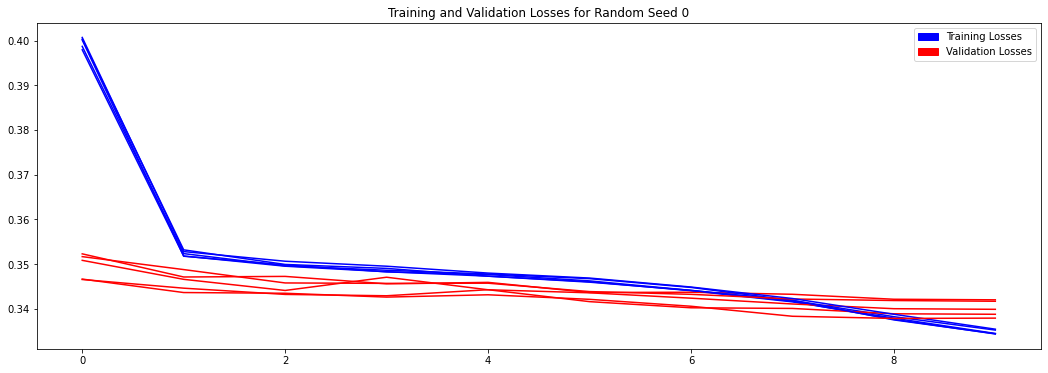

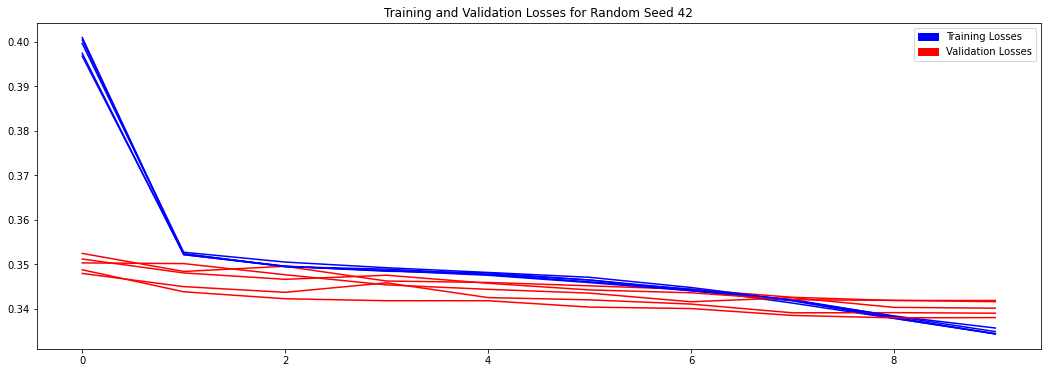

In [15]:
#placeholder - out of fold predictions
oof = np.zeros((len(features), ))

#placeholder - test predictions
predictions = np.zeros((len(test_features), ))

for rs in CFG['random_seeds']:
    #run the training with different random seeds to get out of fold and test averages
    oof_, predictions_ = run_training(features, Y, test_features, folds, 
                                seed=rs,
                                batch_size=CFG['mlp_batch_size'], 
                                model_name='model',
                                num_features=test_features.shape[1],
                                num_targets=1,
                                hidden_size=CFG['mlp_hidden_size'])
    
    oof+=oof_
    predictions+=predictions_
    
oof/=len(CFG['random_seeds'])
predictions/=len(CFG['random_seeds'])

<AxesSubplot:ylabel='Density'>

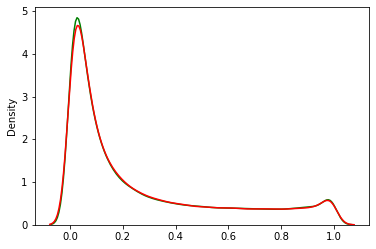

In [16]:
sns.kdeplot(oof,color='Green')
sns.kdeplot(predictions,color='Red')

In [17]:
oof_df = pd.read_csv(PATH+'train.csv')[['id', 'target']]
oof_df['oof_prediction'] = oof

print('CV Score', roc_auc_score(oof_df['target'], oof_df['oof_prediction']))
oof_df.to_csv(SAVE_PATH+f'mlp_{run_key}_oof.csv', index=False)
oof_df.head(10)

CV Score 0.8974553750416852


,id,target,oof_prediction
0,0,0,0.088746
1,1,0,0.296932
2,2,0,0.049695
3,3,0,0.050672
4,4,1,0.369846
5,7,0,0.005599
6,10,0,0.258613
7,12,1,0.963598
8,13,0,0.005122
9,14,1,0.979038


In [18]:
submission = pd.read_csv(PATH+'sample_submission.csv')
submission['target'] = predictions
submission.to_csv(SAVE_PATH+f'mlp_{run_key}_submission.csv', index=False)
submission.head(5)

,id,target
0,5,0.144517
1,6,0.490025
2,8,0.005897
3,9,0.238922
4,11,0.096264
